In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(37)
np.random.seed(37)

from scipy.signal import detrend

In [2]:
! cp /content/drive/MyDrive/Colab\ Notebooks/transient_detection/gps_signal.py .
from gps_signal import transient, seasonal, colored_noise, outliers

In [3]:
home_dir = '/content/drive/MyDrive/Colab Notebooks/transient_detection/'

In [5]:
model = tf.keras.models.load_model(home_dir+'sequence_model_0.h5')

In [6]:
n_epoch = 1000
n_sample = 10000

In [7]:
from sklearn.preprocessing import minmax_scale

In [21]:
def random_noise(direction=0):
  if direction == 'v':
    d_seasonal = seasonal(n_epoch, [4.5,6.9], [0.7,1.5])
    d_noise = colored_noise(n_epoch, [2.0, 2.9], [2.3, 5.9], [0, 2.9])
    d_outliers = outliers(n_epoch, 10, 0.05)
  elif direction =='h':
    d_seasonal = seasonal(n_epoch, [1,2], [0.2,0.5])
    d_noise = colored_noise(n_epoch, [0.4, 0.9], [0.3, 1.6], [0, 1.4])
    d_outliers = outliers(n_epoch, 5, 0.05)
  return d_seasonal + d_noise + d_outliers


def make_test_dataset(size, direction):

  duration = 2*(size + 1)
  center = 365
  d_transient = transient(n_epoch, size, duration, center)

  label = np.zeros((n_sample, n_epoch))
  label[:, np.int(center - duration/2 - 15): np.int(center + duration/2 + 15)] = 1

  data = np.zeros((n_sample, n_epoch))
  for i in range(n_sample):
    data[i,:] = random_noise(direction) + d_transient

  data = minmax_scale(detrend(data, axis=1), axis=1)

  return data, label

In [41]:
def compute_confusion(y_true, y_pred, threshold=0.5):
  diff_y_true = np.diff(y_true,n=1,axis=1)
  tp, tn, fp, fn = 0, 0, 0, 0
  for i in range(n_sample):
    start_indices = np.nonzero(diff_y_true[i,:]==1)[0] + 1
    end_indices = np.nonzero(diff_y_true[i,:]==-1)[0] + 1

    if len(start_indices) == 0:
      tn += np.sum(y_pred[i, :] < threshold)
      fp += np.sum(y_pred[i, :] >= threshold)
    else:
      tn += np.sum(y_pred[i, 0:start_indices[0]] < threshold)
      fp += np.sum(y_pred[i, 0:start_indices[0]] >= threshold)

      n_event = len(start_indices)
      for k in range(n_event):
        if np.any(y_pred[i, start_indices[k]: end_indices[k]] >= threshold):
          tp += 1
          #print(tp)
        else:
          fn += 1

      tn += np.sum(y_pred[i, end_indices[-1]:] < threshold)
      fp += np.sum(y_pred[i, end_indices[-1]:] >= threshold)

  C = np.array([[tn,fp],[fn, tp]])
  return tn, fp, fn, tp

In [42]:
size_vec = np.arange(0, 51)
n_test = len(size_vec)
h_precision_vec = np.zeros(n_test)
h_recall_vec = np.zeros(n_test)
v_precision_vec = np.zeros(n_test)
v_recall_vec = np.zeros(n_test)

In [43]:
def evaluate(data, label):
  pred = np.squeeze(model.predict(data[:,:, np.newaxis]))
  tn, fp, fn, tp = compute_confusion(label, pred)
  precision_val = tp/(tp + fp)
  recall_val = tp/(tp + fn)
  return precision_val, recall_val

for i in range(n_test):
  data, label = make_test_dataset(size_vec[i], 'h')
  h_precision_vec[i], h_recall_vec[i] = evaluate(data, label)

  data, label = make_test_dataset(size_vec[i], 'v')
  v_precision_vec[i], v_recall_vec[i] = evaluate(data, label)

In [44]:
result = np.vstack((size_vec,h_precision_vec, h_recall_vec, v_precision_vec, v_recall_vec)).transpose()

np.savetxt(home_dir + 'synthetic_test_results.txt', result, fmt='%.4f')

In [15]:
A = np.loadtxt(home_dir + 'synthetic_test_results.txt')
size_vec = A[:,0]
h_precision_vec = A[:,1]
h_recall_vec = A[:,2]
v_precision_vec = A[:,3]
v_recall_vec = A[:,4]

In [25]:
plt.rcParams['font.size'] = 12

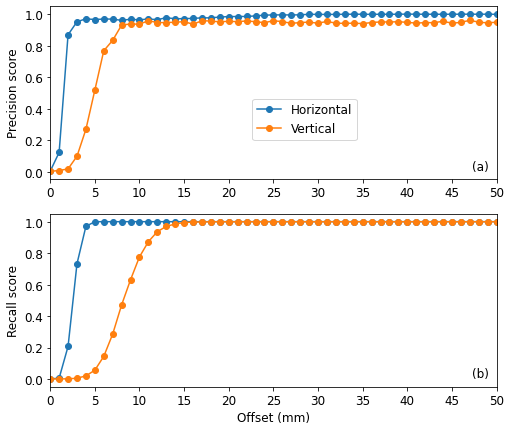

In [42]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.plot(size_vec, h_precision_vec, 'o-')
plt.plot(size_vec, v_precision_vec, 'o-')
plt.legend(['Horizontal', 'Vertical'], bbox_to_anchor=(0.7,0.5))
plt.xticks(np.arange(0, 51, 5))
plt.xlim(0,50)
plt.text(47.3,0.01,'(a)')
plt.ylabel('Precision score')

plt.subplot(2,1,2)
plt.plot(size_vec, h_recall_vec, 'o-')
plt.plot(size_vec, v_recall_vec, 'o-')
plt.text(47.3,0.01,'(b)')
plt.xticks(np.arange(0, 51, 5))
plt.xlim(0,50)
plt.ylabel('Recall score')
plt.xlabel('Offset (mm)')
plt.savefig('precision_recall.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)